In [1]:
!echo "* How many seconds are left in my Jupyter Notebook session?"
!qstat -f $PBS_JOBID | grep Walltime.Remaining

!echo "* How many logical CPUs do I have for the Notebook?"
!taskset -c -p $$

!echo "* How much RAM can I use in the Notebook?"
!/usr/local/bin/qstat -f $PBS_JOBID | grep vmem

* How many seconds are left in my Jupyter Notebook session?
    Walltime.Remaining = 13051
* How many logical CPUs do I have for the Notebook?
pid 100373's current affinity list: 0-5,12-17
* How much RAM can I use in the Notebook?
    resources_used.vmem = 1494168kb
    Resource_List.vmem = 48gb


In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
from keras.datasets import cifar10
import matplotlib.pyplot as plt




In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [5]:
print(x_train[1].shape,x_test.shape)

(32, 32, 3) (10000, 32, 32, 3)


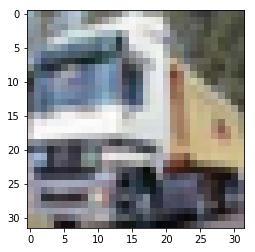

In [6]:
plt.imshow(x_train[1])
plt.show()

In [7]:
def placeholder_create(input_Shape,cls):
    nh=input_Shape[0]
    nw=input_Shape[1]
    nc=input_Shape[2]
    X = tf.placeholder(tf.float32,[None,nh,nw,nc])
    Y = tf.placeholder(tf.float32,[None,cls])
    return X,Y
    

In [8]:
y_train.shape

(50000, 1)

In [9]:
X,Y = placeholder_create(x_train[1].shape,120)
gram = X*10

print(X,Y)
with tf.Session() as sess:
    Y=sess.run(gram,{X:x_train})
#     xxx=sess.run(X)
    print(X.shape)

Tensor("Placeholder:0", shape=(?, 32, 32, 3), dtype=float32) Tensor("Placeholder_1:0", shape=(?, 120), dtype=float32)
(?, 32, 32, 3)


In [10]:
print(x_train[2].shape)

(32, 32, 3)


In [11]:
d = x_train[2].shape

In [12]:
print(d[1])

32


In [13]:
def parameter_initialize():
    parameter={}
    
    W1 = tf.get_variable("W1",shape=[4, 4, 3, 8],initializer = tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2",shape=[3, 3, 8, 12],initializer = tf.contrib.layers.xavier_initializer(seed=0))
    W3 = tf.get_variable("W3",shape=[2, 2, 12, 16],initializer = tf.contrib.layers.xavier_initializer(seed=0))
    parameter = {"W1":W1,"W2":W2,"W3":W3 }
    return parameter

In [14]:
tf.reset_default_graph()
with tf.Session() as sess:
    parameter = parameter_initialize()
    init = tf.global_variables_initializer()  
    print(sess.run(init))
    wt = parameter["W1"].eval()
print(wt.shape)

None
(4, 4, 3, 8)


In [57]:
def cost(Y,logitss):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y,logits=logitss))
    return loss


In [91]:
def forward_conv(parameter,X):
    W1 = parameter["W1"]
    W2 = parameter["W2"]
    W3 = parameter["W3"]
    X = tf.nn.conv2d(X,W1,strides=[1,1,1,1],padding = 'SAME')
    X = tf.nn.max_pool(X,ksize=[1,4,4,1],strides=[1,2,2,1],padding ='SAME')
    X = tf.nn.relu(X)
    X = tf.nn.conv2d(X,W2,strides=[1,2,2,1],padding='SAME')
    X = tf.nn.max_pool(X,ksize=[1,3,3,1],strides=[1,2,2,1],padding='SAME')
    X = tf.nn.relu(X)
    X = tf.nn.conv2d(X,W3,strides=[1,1,1,1],padding ='SAME')
    X = tf.nn.relu(X)
    X = tf.nn.max_pool(X,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    X = tf.contrib.layers.flatten(X)
    X = tf.contrib.layers.fully_connected(X, num_outputs=10)
    return X
    
    

In [117]:
def random_mini_batches(Xtrain,Ytrain,batch_size,seed):
    m = Xtrain.shape[0] #number of training examples
    permutation = list(np.random.permutation(m))
    mini_batches = []
    
    X_shuffled = Xtrain[permutation,:,:,:]
    Y_shuffled = Ytrain[permutation,:]
    number_of_minibatches = int(m/batch_size)
    for l in range(number_of_minibatches):
        X_mini_batch = X_shuffled[l*batch_size:(l+1)*batch_size,:,:,:]
        Y_mini_batch = Y_shuffled[l*batch_size:(l+1)*batch_size,:]
#         print(Y_mini_batch.shape)
        mini_batch = (X_mini_batch,Y_mini_batch)
        mini_batches.append(mini_batch)
        
    if m%batch_size !=0:
        X_mini_batch = X_shuffled[number_of_minibatches*batch_size:m,:,:,:]
        Y_mini_batch = Y_shuffled[number_of_minibatches*batch_size:m,:]
        mini_batch = (X_mini_batch,Y_mini_batch)
#         print(Y_mini_batch.shape)
        mini_batches.append(mini_batch)
    return mini_batches

In [118]:
def backward_propagation(xtrain,ytrain,learning_rate,batch_size,epochs,beta1,beta2):
    tf.reset_default_graph()
    cls = 10
    input_Shape = xtrain[1].shape 
    X,Y = placeholder_create(input_Shape,cls)
    parameter = parameter_initialize()
    Z = forward_conv(parameter,X)
    loss = cost(Y,Z)
    optimizer = tf.train.AdamOptimizer( learning_rate=0.001,beta1=0.9, beta2=0.999,epsilon=1e-08,name='Adam').minimize(loss)
    init = tf.global_variables_initializer() 
    with tf.Session() as sess:
        sess.run(init)
        batch_size = 64
        seed = 0
        costs=[]
        for epoch in range(epochs):
            seed = seed+1
            batch_Size = (xtrain.shape[0])/batch_size
            mini_batches = random_mini_batches(xtrain,ytrain,batch_size,seed)
            for mini_batch in mini_batches:
                xtr,ytr = mini_batch
                _,cst = sess.run([optimizer,loss],{X:xtr,Y:ytr})
                csts = cst/batch_Size
            while(epoch%5==0):
                print(csts)
        parameter = sess.run(parameter)
        costs.append(csts)
        plt.plot(costs)
        plt.xlabel('number of iterations')
        plt.ylabel('costs')
    return parameter

In [119]:
permutation = list(np.random.permutation(x_train.shape[0]))
X_shuffled = x_train[permutation,:,:,:]
print (y_train[permutation,:].shape) 

(50000, 1)


In [134]:
ytr = tf.one_hot(indices=y_train,depth=10)
with tf.Session() as sess:
    ylan=sess.run(ytr)
ynw = ylan.reshape(50000,10)
print(ynw.shape)

(50000, 10)


In [120]:
learning_rate = .001
batch_size = 64
epochs = 3
beta1 = .9
beta2 = .999
parameter = backward_propagation(x_train,y_train,learning_rate,batch_size,epochs,beta1,beta2)

ValueError: Cannot feed value of shape (64, 1) for Tensor 'Placeholder_1:0', which has shape '(?, 10)'

In [114]:
print(x_train.shape[0])

50000


In [19]:
print(X_shuffled.shape)

(50000, 32, 32, 3)


In [27]:
print(y_train[:50,:].shape)

(50, 1)


In [23]:
X_mini_batch = X_shuffled[0*64:1*64,:,:,:]

In [24]:
print(X_mini_batch.shape)

(64, 32, 32, 3)


In [ ]:
X_shuffled[l*batch_size:(l+1)*batch_size,:,:,:]

In [115]:
mini_batches = random_mini_batches(x_train,y_train,64,0) 

(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)


In [99]:
for mini_b in mini_batches:
    Xtr,ytr = mini_b
    print(ytr.shape)

(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32, 32, 3)
(64, 32,